## Step0: Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

## Step1: Data Preparation

In [7]:
# reading the dataset
data = pd.read_csv('/content/data.csv')
data.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


## Step2: Data description

In [8]:
# checking the dimension of dataset
data.shape

(4009, 4)

In [9]:
# checking if there is any null value
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      4009 non-null   object
 1   Headline  4009 non-null   object
 2   Body      3988 non-null   object
 3   Label     4009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.4+ KB


## Step3: Analysis

In [10]:
# dropping rows where there is any null value
data.dropna(inplace=True, axis=0)

# taking only the name of website from the URLs
pattern = 'https?://([\w.]+)/'
data['Website'] = data.URLs.str.extract(pattern)
data.drop('URLs', axis=1, inplace=True)

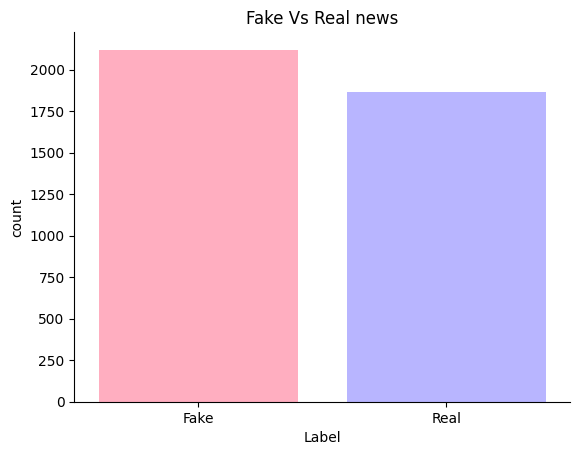

In [11]:
# making a bar plot to count the frequency of
# fake and real news
sns.countplot(x='Label',
              data=data,
              palette=['#ffaec0', '#b8b5ff'],
              saturation=1)
sns.despine()
plt.xticks([0,1], ['Fake', 'Real'])
plt.title('Fake Vs Real news');

In [12]:
fake_news_count = data[data.Label == 0]['Website'].value_counts()
real_news_count = data[data.Label == 1]['Website'].value_counts()
print(fake_news_count)
print(real_news_count)

beforeitsnews.com       1681
www.activistpost.com     267
dailybuzzlive.com         99
www.disclose.tv           71
Name: Website, dtype: int64
www.reuters.com              646
www.cnn.com                  389
www.nytimes.com              341
www.bbc.com                  333
abcnews.go.com                57
money.cnn.com                 49
edition.cnn.com               15
inhealth.cnn.com              14
www.bbc.co.uk                 10
bleacherreport.com             8
clarivate.com                  3
reuters.com                    1
cnn.it                         1
thelab.bleacherreport.com      1
Name: Website, dtype: int64


In [13]:
fdf = pd.DataFrame({
    'Web':fake_news_count.index,
    'Fake':fake_news_count.values
})

rdf = pd.DataFrame({
    'Web':real_news_count.index,
    'Real':real_news_count.values
})
print(fdf)
print(rdf)

                    Web  Fake
0     beforeitsnews.com  1681
1  www.activistpost.com   267
2     dailybuzzlive.com    99
3       www.disclose.tv    71
                          Web  Real
0             www.reuters.com   646
1                 www.cnn.com   389
2             www.nytimes.com   341
3                 www.bbc.com   333
4              abcnews.go.com    57
5               money.cnn.com    49
6             edition.cnn.com    15
7            inhealth.cnn.com    14
8               www.bbc.co.uk    10
9          bleacherreport.com     8
10              clarivate.com     3
11                reuters.com     1
12                     cnn.it     1
13  thelab.bleacherreport.com     1


In [14]:
rf_count = pd.merge(rdf, fdf, on='Web', how='outer').fillna(0)
rf_count['Real'] = rf_count['Real'].astype(int)
rf_count['Fake'] = rf_count['Fake'].astype(int)
rf_count

,Web,Real,Fake
0,www.reuters.com,646,0
1,www.cnn.com,389,0
2,www.nytimes.com,341,0
3,www.bbc.com,333,0
4,abcnews.go.com,57,0
5,money.cnn.com,49,0
6,edition.cnn.com,15,0
7,inhealth.cnn.com,14,0
8,www.bbc.co.uk,10,0
9,bleacherreport.com,8,0


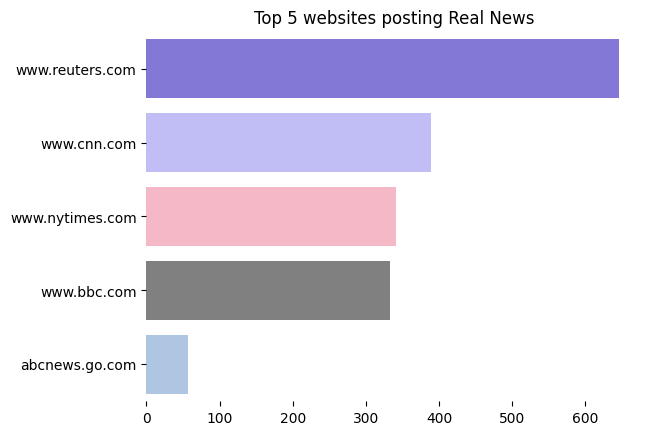

In [15]:
sns.barplot(y=real_news_count[:5].index, x=real_news_count[:5].values,
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey', '#a7c5eb'])
sns.despine(bottom=True, left=True)
plt.title('Top 5 websites posting Real News');

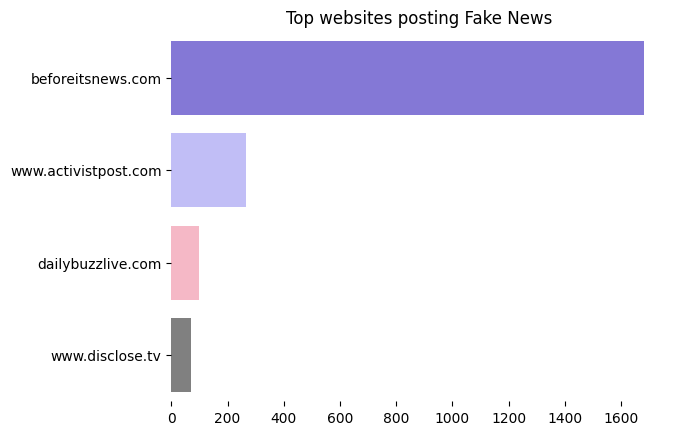

In [16]:
sns.barplot(y=fake_news_count.index, x=fake_news_count.values,
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey'])
sns.despine(bottom=True, left=True)
plt.title('Top websites posting Fake News');

## Step4: Text cleaning

In [20]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [21]:
lm = WordNetLemmatizer()
def clean_text(column):
    corpus = []
    for value in column:
        # convert each word into lower case
        value = value.lower()
        # take only alphabets
        value = re.sub('[^a-z]', ' ', value)
        value = value.split()
        # lemmatizing those words which are not stop words
        value = [lm.lemmatize(word) for word in value\
                 if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(value))
    return corpus

# taking both headline and body of news into a single column
data['Text'] = data['Headline'] + ' ' + data['Body']
data['Text'] = clean_text(data.Text)

In [22]:
lm = WordNetLemmatizer()
def clean_text(column):
    corpus = []
    for value in column:
        # convert each word into lower case
        value = value.lower()
        # take only alphabets
        value = re.sub('[^a-z]', ' ', value)
        value = value.split()
        # lemmatizing those words which are not stop words
        value = [lm.lemmatize(word) for word in value\
                 if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(value))
    return corpus

# taking both headline and body of news into a single column
data['Text'] = data['Headline'] + ' ' + data['Body']
data['Text'] = clean_text(data.Text)

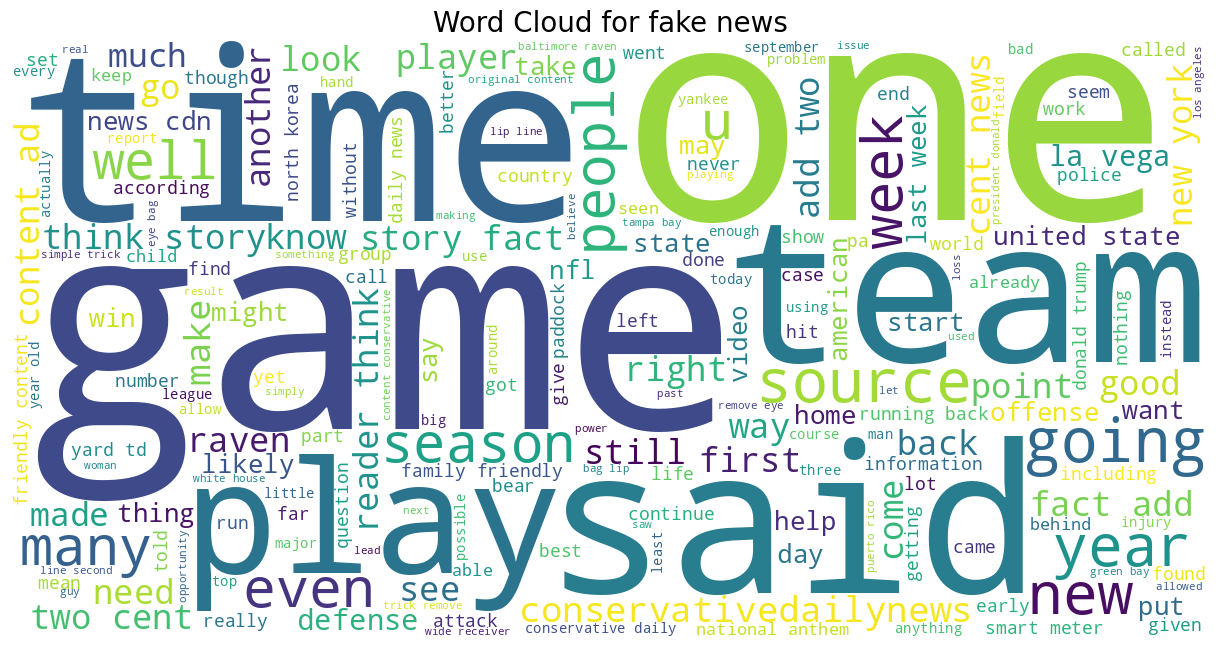

In [26]:
from wordcloud import WordCloud, STOPWORDS
sw = set(STOPWORDS)

fake_news = data[data.Label == 0]
real_news = data[data.Label == 1]

# wordcloud for fake news
fake_wc = WordCloud(width = 1200, height = 600,
                    background_color ='white',
                    stopwords = sw,
                    min_font_size = 10).generate(' '.join(fake_news.Text))

# plot the WordCloud image
plt.figure(figsize = (12, 6), facecolor = None)
plt.imshow(fake_wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud for fake news', fontsize=20);

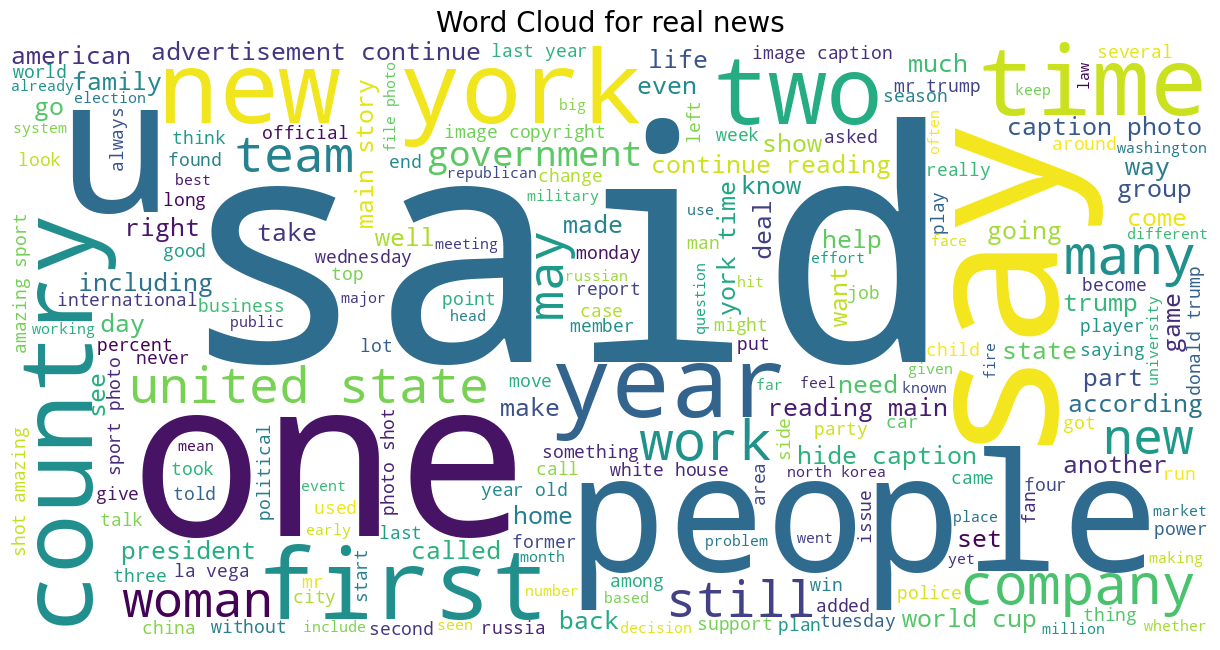

In [27]:
# wordcloud for real news
real_wc = WordCloud(width = 1200, height = 600,
                    background_color ='white',
                    stopwords = sw,
                    min_font_size = 10).generate(' '.join(real_news.Text))

# plot the WordCloud image
plt.figure(figsize = (12, 6), facecolor = None)
plt.imshow(real_wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud for real news', fontsize=20);

## Step5: Modeling

In [28]:
# one hot representation of words
oh_repr = [one_hot(words, 5000) for words in data.Text]

In [29]:
# list to store length of words in each news
len_list = []
for w in data.Text:
    w = w.split()
    len_list.append(len(w))

print('Summary of word length :')
pd.Series(len_list).describe()

Summary of word length :


count    3988.000000
mean      289.271063
std       289.423529
min        10.000000
25%        65.000000
50%       217.000000
75%       419.000000
max      3171.000000
dtype: float64

In [30]:
# taking sentences length as 400
sent_length = 400
# padding
embedded_doc = pad_sequences(oh_repr, padding='pre', maxlen=sent_length)
embedded_doc[:5]

array([[4692, 1920, 3823, ..., 4512,  138, 3185],
       [   0,    0,    0, ..., 2923, 1157, 1178],
       [ 249, 4768,  949, ..., 4599,  163, 2637],
       [   0,    0,    0, ..., 2498, 1151, 4373],
       [   0,    0,    0, ..., 4346, 1115,   76]], dtype=int32)

In [31]:
# initializing model
model = Sequential()
# adding embedding layer
model.add(Embedding(5000, 100, input_length=sent_length))
model.add(LSTM(150))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 100)          500000    
                                                                 
 lstm (LSTM)                 (None, 150)               150600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 650,751
Trainable params: 650,751
Non-trainable params: 0
_________________________________________________________________


In [32]:
x = np.array(embedded_doc)
y = data.Label

# splitting the dataset into train and test
train_x, test_x, train_y, test_y = train_test_split(x, y,
                                                    test_size=0.25, random_state=3)

In [33]:
# fitting the model
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=64)

Epoch 1/10
47/47 [==============================] - 79s 2s/step - loss: 0.3652 - accuracy: 0.8144 - val_loss: 0.1036 - val_accuracy: 0.9629
Epoch 2/10
47/47 [==============================] - 72s 2s/step - loss: 0.0907 - accuracy: 0.9783 - val_loss: 0.0989 - val_accuracy: 0.9689
Epoch 3/10
47/47 [==============================] - 67s 1s/step - loss: 0.0187 - accuracy: 0.9970 - val_loss: 0.0775 - val_accuracy: 0.9679
Epoch 4/10
47/47 [==============================] - 65s 1s/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 0.0831 - val_accuracy: 0.9749
Epoch 5/10
47/47 [==============================] - 67s 1s/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0750 - val_accuracy: 0.9779
Epoch 6/10
47/47 [==============================] - 67s 1s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0962 - val_accuracy: 0.9769
Epoch 7/10
47/47 [==============================] - 68s 1s/step - loss: 6.1491e-04 - accuracy: 1.0000 - val_loss: 0.0972 - val_accuracy: 0.9729
Epoch 8/10
47/47

In [34]:
pred = (model.predict(test_x) > 0.5).astype("int32")

32/32 [==============================] - 9s 266ms/step


## Step6: Confusion matrix and Accuracy

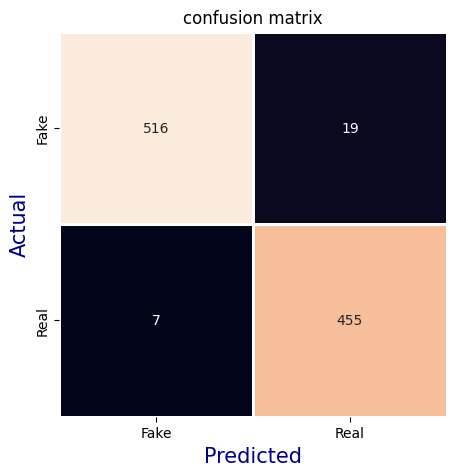

In [35]:
# plotting graph for confusion matrix
cm = confusion_matrix(test_y, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='', cbar=False, linewidths=2,
            xticklabels = ['Fake','Real'], yticklabels = ['Fake','Real'])
plt.title('confusion matrix')
plt.xlabel('Predicted', color='navy', fontsize=15)
plt.ylabel('Actual', color='navy', fontsize=15);

In [36]:
# accuracy of the model we built
accuracy_score(test_y, pred)

0.9739217652958877